In [1]:
!pip install opendatasets --upgrade --quiet

In [3]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'

od.download(dataset_url)

  1%|▏         | 5.00M/395M [00:00<00:13, 29.9MB/s]

100%|██████████| 395M/395M [00:08<00:00, 51.1MB/s]


In [1]:
import os 
from image_info import Image_info 
import numpy as np


DATA_DIR = 'animefacedataset'
total_images_in_dataset = len(os.listdir(DATA_DIR+'/images'))
print("Total images : ",total_images_in_dataset)




Total images :  63565


Image Shape :  (104, 104, 3)
Number of channels :  3
Image height :  104
Image width :  104


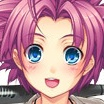

In [2]:
# getting a random image 

random_index = np.random.randint(0,total_images_in_dataset)
random_image_path = DATA_DIR+'/images/'+os.listdir(DATA_DIR+'/images')[random_index]

random_image = Image_info(random_image_path)
random_image.show_details()



In [3]:
# making dataset and data loader with Data Augmentation and Normalization
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T


In [4]:
image_size = 64
batch_size = 128
stats = (0.5,0.5,0.5),(0.5,0.5,0.5) 

In [5]:
train_ds = ImageFolder(DATA_DIR, T.Compose([T.Resize(image_size),
                                                 T.CenterCrop(image_size),
                                                 T.ToTensor(),
                                                 T.Normalize(*stats)]))
train_loader = DataLoader(train_ds, batch_size,shuffle=True, num_workers=2,pin_memory=True)

In [6]:
#  helper functionto denormalize the normalized image ( for better visual only )
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline


In [7]:
def denorm(img_tensors):
  return img_tensors*stats[1][0] +stats[0][0]   # for each channel , adding the mean and multiplying by std

def show_images(images, nmax = 64):


    fig , ax = plt.subplots(figsize= (8,8))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]),nrow=8).permute(1,2,0))


def show_batch(dl , nmax = 64):
  for images , _ in dl : 
    show_images(images, nmax)
    break



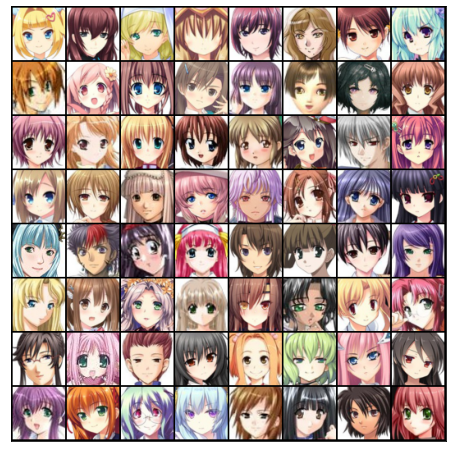

In [8]:
show_batch(train_loader)

## Using GPU

In [9]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [10]:
device = get_default_device()
device

device(type='cuda')

In [29]:
train_dl = DeviceDataLoader(train_loader,device)

In [11]:
# creatin a neural network named discriminator which can discriminate between real image or fake image . 

import torch.nn as nn

discriminator = nn.Sequential(
    

    # 3 x 64 x 64
    nn.Conv2d(3,64,kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2,inplace=True),

    # 64 x 32 x 32
    nn.Conv2d(64,128,kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2,inplace=True),

    # 128 x 16 x 16
    nn.Conv2d(128,256,kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2,inplace=True),

    # 256 x 8 x 8
    nn.Conv2d(256,512,kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2,inplace=True),

    # 512 x 4 x 4 
    nn.Conv2d(512,1, kernel_size=4, stride=1, padding=0 , bias=False),

    # 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()


)



## test the output 

In [12]:
discriminator = to_device(discriminator, device)


In [13]:
# Generator Network 

latent_size = 128

In [14]:
generator = nn.Sequential(
    
    # latent_size x 1 x 1
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4,stride=1,padding=0, bias = False),
    nn.BatchNorm2d(512),
    nn.ReLU(),

    # 512 x 4 x 4

    nn.ConvTranspose2d(512,256 , kernel_size=4 , stride=2, padding=1, bias =False),
    nn.BatchNorm2d(256),
    nn.ReLU(),

    # 256 x 8 x 8 
    nn.ConvTranspose2d(256,128, kernel_size=4, stride=2, padding = 1, bias = False),
    nn.BatchNorm2d(128),
    nn.ReLU(),

    # 128 x 16 x 16
    nn.ConvTranspose2d(128,64, kernel_size=4, stride=2, padding = 1, bias = False),
    nn.BatchNorm2d(64),
    nn.ReLU(),

    # 64 x 32 x 32
    nn.ConvTranspose2d(64,3, kernel_size=4, stride=2, padding = 1, bias = False),
    nn.Tanh()  #  to have the output in range (-1,1) just like normalized value

    # 3 x 64 x 64


)

xb.shape:  torch.Size([128, 128, 1, 1])
fake_images.shape :  torch.Size([128, 3, 64, 64])
each fake image shape :  torch.Size([3, 64, 64])


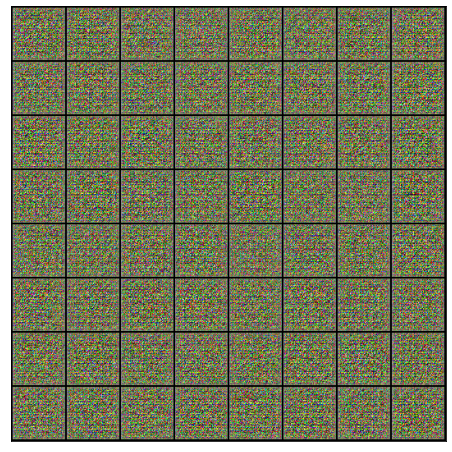

In [16]:
# generating image 
xb = torch.randn(batch_size, latent_size,1,1 , device = device)
print("xb.shape: ",xb.shape)
fake_images = generator(xb.cpu())
print("fake_images.shape : ", fake_images.shape)
print("each fake image shape : " , fake_images[0].shape)
show_images(fake_images.cpu())

In [17]:
# taking the generator to device
generator = to_device(generator,device)

## Training 

###  Discriminator Training 

In [18]:
def train_discriminator(real_images, opt_d):
  # clearing discriminator gradients
  opt_d.zero_grad()

  # passing real image to the discriminatior
  real_preds = discriminator(real_images)
  real_targets = torch.ones(real_images.size(0),1,device = device)
  real_loss = F.binary_cross_entropy(real_preds, real_targets)
  real_score = torch.mean(real_preds).item()


  # generate fake image 

  latent = torch.randn(batch_size, latent_size, 1,1, device = device)
  fake_images = generator(latent)


  # passing fake image to the discriminator

  fake_preds = discriminator(fake_images)
  fake_targets = torch.zeros(fake_images.size(0), 1, device = device)
  fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
  fake_score = torch.mean(fake_preds).item()


  # update the loss

  loss = real_loss + fake_loss
  loss.backward()
  opt_d.step()

  return loss.item() , real_score, fake_score



### Generator Training

In [19]:
def train_generator(opt_g):

  # clearing opt_g gradients 

  opt_g.zero_grad()

  # generate fake image

  latent = torch.randn(batch_size, latent_size, 1,1, device=device)
  fake_images = generator(latent)

  # try to fool the discriminator 
  
  preds = discriminator(fake_images)
  targets = torch.ones(batch_size,1, device = device)   # fake_images.size(0) == batch_size
  loss = F.binary_cross_entropy(preds, targets)

  # update the generator with weights 

  loss.backward()
  opt_g.step()

  return loss.item()


## saving sample images in directory

In [20]:
from torchvision.utils import save_image

In [21]:
sample_dir = "generated"
#make directory 
os.makedirs(sample_dir, exist_ok=True)




In [22]:
# defining a function for saving the output batch images 

def save_samples(index, latent_tensor, show = True):
  fake_images = generator(latent_tensor)
  fake_name = 'generated-images-{0:0=4d}.png'.format(index)
  save_image(denorm(fake_images),os.path.join(sample_dir,fake_name),nrow = 8)
  print("Saving ",fake_name)
  if show: 
    fig , ax = plt.subplots(figsize = (8,8))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(fake_images.cpu().detach(), nrow = 8).permute(1,2,0))


In [23]:
fixed_latent = torch.randn(64,latent_size,1,1,device=device) # fixing one latent tensor so that we can see the evolution on it as out model learns to generate 



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving  generated-images-0000.png


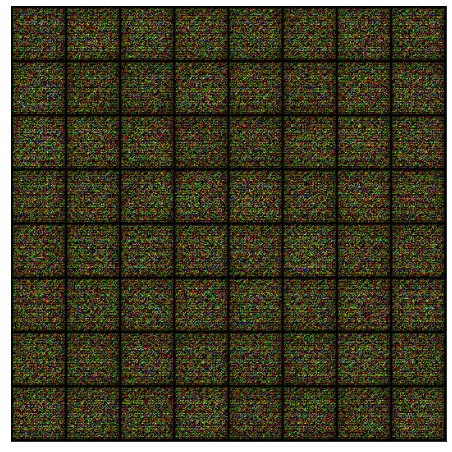

In [24]:
save_samples(0,fixed_latent)

# Main Fit Function

In [25]:
from tqdm.notebook import tqdm
import torch.nn.functional as F


In [36]:
def fit(epochs, lr, start_idx = 1):

  # setting free gpu 
  torch.cuda.empty_cache()

  # losses and scores

  losses_g = []
  losses_d = []
  real_scores = []
  fake_scores = []

  # create optimizers 

  opt_d = torch.optim.Adam(discriminator.parameters(),lr = lr , betas = (0.5, 0.999))
  opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

  for epoch in range(epochs):
    for real_images, _ in tqdm(train_dl):
      # train discriminator 
      loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
      
      # train generator 
      loss_g = train_generator(opt_g)
    

    losses_g.append(loss_g)
    losses_d.append(loss_d)
    real_scores.append(real_score)
    fake_scores.append(fake_score)

    # log losses and scores 

    print("Epoch[{}/{}] , loss_g : {:.4f} , loss_d : {:.4f} , real_score : {:.4f} , fake_score : {:.4f}".format(epoch+1,epochs,loss_g,loss_d,real_score,fake_score))


    # save generated image 

    save_samples(epoch+start_idx,fixed_latent,show=False)  

  return losses_g, losses_d , real_scores , fake_scores




In [39]:
lr = 0.002
epochs = 30

In [40]:
history = fit(epochs=epochs,lr = lr)


Epoch[1/30] , loss_g : 4.8047 , loss_d : 0.9876 , real_score : 0.7721 , fake_score : 0.4483
Saving  generated-images-0001.png



Epoch[2/30] , loss_g : 7.4130 , loss_d : 1.0754 , real_score : 0.9311 , fake_score : 0.5509
Saving  generated-images-0002.png



Epoch[3/30] , loss_g : 4.5353 , loss_d : 0.4586 , real_score : 0.8513 , fake_score : 0.2095
Saving  generated-images-0003.png



Epoch[4/30] , loss_g : 3.5513 , loss_d : 0.4887 , real_score : 0.7768 , fake_score : 0.1244
Saving  generated-images-0004.png



Epoch[5/30] , loss_g : 4.5762 , loss_d : 0.4931 , real_score : 0.7073 , fake_score : 0.0153
Saving  generated-images-0005.png



Epoch[6/30] , loss_g : 7.3970 , loss_d : 0.3674 , real_score : 0.9591 , fake_score : 0.2243
Saving  generated-images-0006.png



Epoch[7/30] , loss_g : 2.7566 , loss_d : 0.3962 , real_score : 0.7238 , fake_score : 0.0155
Saving  generated-images-0007.png



Epoch[8/30] , loss_g : 6.5620 , loss_d : 0.2555 , real_score : 0.9482 , fake_score : 0.1467
Saving  generated-images-0008.png



Epoch[9/30] , loss_g : 5.3903 , loss_d : 0.3021 , real_score : 0.9161 , fake_score : 0.1453
Saving  generated-images-0009.png



Epoch[10/30] , loss_g : 6.5495 , loss_d : 0.5143 , real_score : 0.9985 , fake_score : 0.3132
Saving  generated-images-0010.png



Epoch[11/30] , loss_g : 6.5004 , loss_d : 0.2827 , real_score : 0.9801 , fake_score : 0.1946
Saving  generated-images-0011.png



Epoch[12/30] , loss_g : 4.8903 , loss_d : 0.4124 , real_score : 0.8881 , fake_score : 0.1814
Saving  generated-images-0012.png



Epoch[13/30] , loss_g : 5.2476 , loss_d : 0.1911 , real_score : 0.9287 , fake_score : 0.0905
Saving  generated-images-0013.png



Epoch[14/30] , loss_g : 4.5860 , loss_d : 0.2330 , real_score : 0.8517 , fake_score : 0.0292
Saving  generated-images-0014.png



Epoch[15/30] , loss_g : 5.3837 , loss_d : 0.0762 , real_score : 0.9760 , fake_score : 0.0472
Saving  generated-images-0015.png



Epoch[16/30] , loss_g : 8.4174 , loss_d : 0.7680 , real_score : 0.9835 , fake_score : 0.4053
Saving  generated-images-0016.png



Epoch[17/30] , loss_g : 4.8076 , loss_d : 0.1136 , real_score : 0.9671 , fake_score : 0.0695
Saving  generated-images-0017.png



Epoch[18/30] , loss_g : 2.1689 , loss_d : 0.3206 , real_score : 0.8172 , fake_score : 0.0243
Saving  generated-images-0018.png



Epoch[19/30] , loss_g : 2.4293 , loss_d : 0.2184 , real_score : 0.8536 , fake_score : 0.0220
Saving  generated-images-0019.png



Epoch[20/30] , loss_g : 3.7269 , loss_d : 0.1811 , real_score : 0.8734 , fake_score : 0.0195
Saving  generated-images-0020.png



Epoch[21/30] , loss_g : 1.1368 , loss_d : 1.8831 , real_score : 0.2982 , fake_score : 0.0015
Saving  generated-images-0021.png



Epoch[22/30] , loss_g : 4.3865 , loss_d : 0.0942 , real_score : 0.9481 , fake_score : 0.0334
Saving  generated-images-0022.png



Epoch[23/30] , loss_g : 5.8448 , loss_d : 0.2266 , real_score : 0.8457 , fake_score : 0.0237
Saving  generated-images-0023.png



Epoch[24/30] , loss_g : 3.4536 , loss_d : 0.1384 , real_score : 0.9914 , fake_score : 0.0967
Saving  generated-images-0024.png



Epoch[25/30] , loss_g : 4.8173 , loss_d : 0.1362 , real_score : 0.9518 , fake_score : 0.0691
Saving  generated-images-0025.png



Epoch[26/30] , loss_g : 0.8351 , loss_d : 1.9082 , real_score : 0.2871 , fake_score : 0.0002
Saving  generated-images-0026.png



Epoch[27/30] , loss_g : 6.9726 , loss_d : 0.0946 , real_score : 0.9377 , fake_score : 0.0177
Saving  generated-images-0027.png



Epoch[28/30] , loss_g : 4.1795 , loss_d : 0.2848 , real_score : 0.8770 , fake_score : 0.1025
Saving  generated-images-0028.png



Epoch[29/30] , loss_g : 5.5099 , loss_d : 0.1393 , real_score : 0.9695 , fake_score : 0.0910
Saving  generated-images-0029.png



Epoch[30/30] , loss_g : 6.0176 , loss_d : 0.1770 , real_score : 0.9260 , fake_score : 0.0372
Saving  generated-images-0030.png


In [43]:
losses_g, losses_d, real_scores, fake_scores = history

In [44]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [45]:
sample_dir

'generated'

In [47]:
os.listdir(sample_dir)[0]

'generated-images-0002.png'

In [49]:
os.path.join(sample_dir,os.listdir(sample_dir)[0])

'generated/generated-images-0002.png'

In [52]:
def sample_names(index):
  return os.path.join(sample_dir,os.listdir(sample_dir)[index])

### Displaying Some image 

In [51]:
from IPython.display import Image

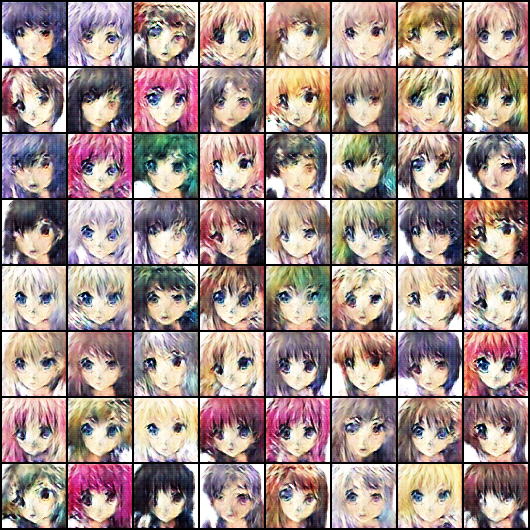

In [54]:
Image(sample_names(0))

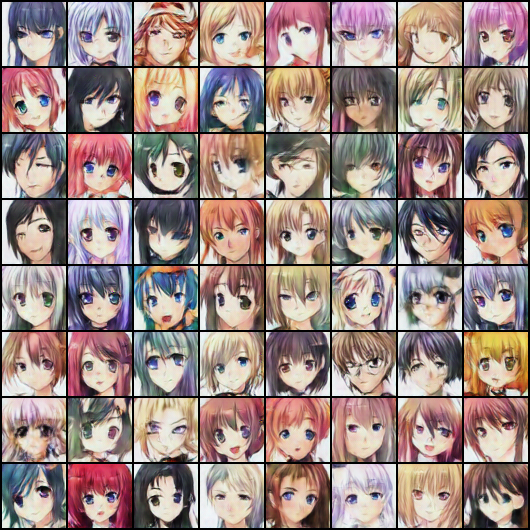

In [55]:
Image(sample_names(10))

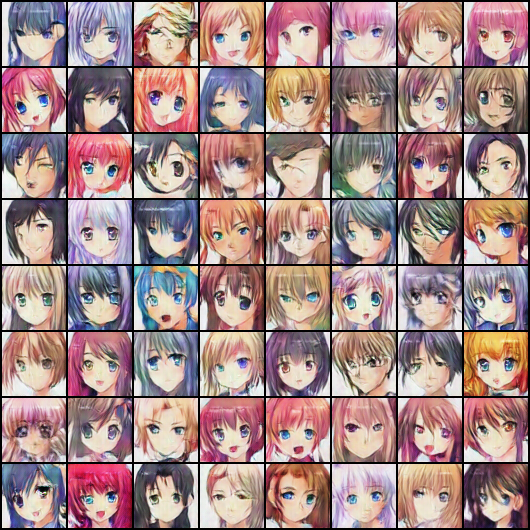

In [56]:
Image(sample_names(20))

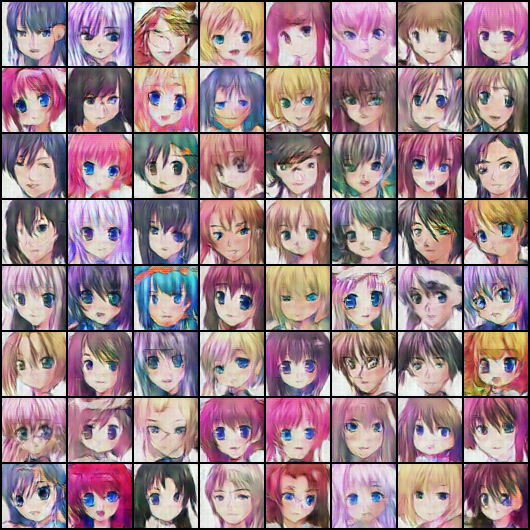

In [58]:
Image(sample_names(-1))

In [57]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

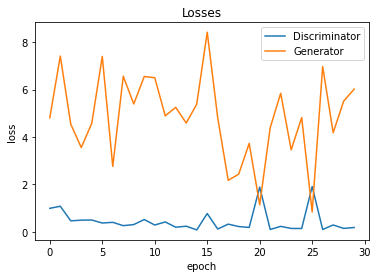

In [59]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

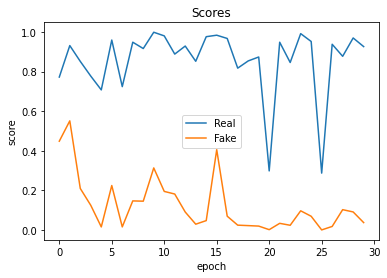

In [60]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');